In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
test = session.query(measurement).first()
test.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1152240a0>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [11]:
for row in session.query(measurement.prcp, measurement.date).limit(15).all():
    print(row)

(0.08, '2010-01-01')
(0.0, '2010-01-02')
(0.0, '2010-01-03')
(0.0, '2010-01-04')
(None, '2010-01-06')
(0.06, '2010-01-07')
(0.0, '2010-01-08')
(0.0, '2010-01-09')
(0.0, '2010-01-10')
(0.01, '2010-01-11')
(0.0, '2010-01-12')
(0.0, '2010-01-14')
(0.0, '2010-01-15')
(0.0, '2010-01-16')
(0.0, '2010-01-17')


In [12]:
inspector=inspect(engine)

columns_meas= inspector.get_columns('measurement')
for column in columns_meas:
    print (column['name'], column['type'])

print('\n*****station_columns*****')
columns_station= inspector.get_columns('station')
for column in columns_station:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

*****station_columns*****
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

2017-08-23
2016-08-23 00:00:00
            precipitation
date                     
2016-08-24           0.08
2016-08-24            NaN
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           2.15
...                   ...
2017-08-22           0.00
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.45

[2223 rows x 1 columns]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


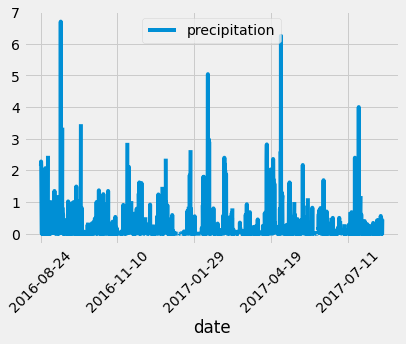

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
##latest date
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
#latest_date = latest_date[0]
print(latest_date[0])
# Calculate the date 1 year ago from the last data point in the database
one_yr = dt.datetime.strptime(latest_date[0],"%Y-%m-%d")- dt.timedelta(days=365)
print(one_yr)
# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_yr).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_scores = pd.DataFrame(query,columns=['date', 'precipitation'])
precip_scores.set_index('date', inplace=True) 
# Sort the dataframe by date
precip_scores_sorted=precip_scores.sort_values('date')
print(precip_scores_sorted)
# Use Pandas Plotting with Matplotlib to plot the data
precip_scores_sorted.plot(rot=45)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_scores_sorted.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations= session.query(measurement.station).distinct().count()
print(f"available stations: {stations}")

available stations: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
(most_active)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
print (most_active[0][0])

USC00519281


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest = session.query(func.min(measurement.tobs), func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).filter(measurement.station == most_active[0][0]).all()
print(lowest)
print (f'lowest tempeture {lowest[0][0]}\nhighest temperturee {lowest[0][1]}\naverage temperture {(round(lowest[0][2],1))}')

[(54.0, 85.0, 71.66378066378067)]
lowest tempeture 54.0
highest temperturee 85.0
average temperture 71.7


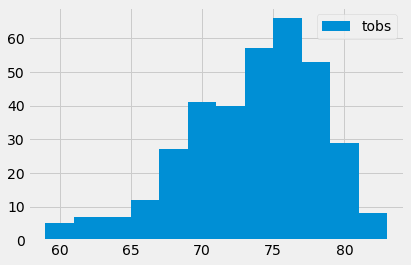

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs = session.query(measurement.tobs).filter(measurement.station ==most_active[0][0]).filter(measurement.date>='2016-08-23').\
filter(measurement.date <='2017-08-23').all()
highest_obs=np.ravel(highest_obs)
highest_obs
plt.hist(highest_obs,bins=12, label='tobs')
plt.legend(loc="best")
plt.show()
# what is Barconatainer?


## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip = calc_temps('2017-08-11', '2017-08-23')
print (f'Tempertures for my trip {calc_temps("2017-08-11", "2017-08-23")}')


Tempertures for my trip [(70.0, 78.67307692307692, 85.0)]


<BarContainer object of 1 artists>

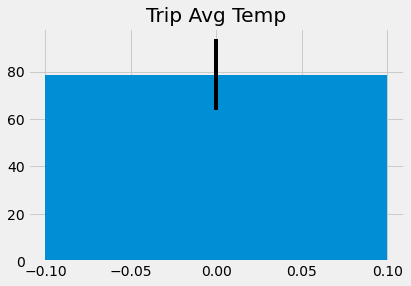

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mytrip_chart = mytrip[0][2] -mytrip[0][0]
avg = mytrip[0][1]
plt.title("Trip Avg Temp")
plt.bar(0,avg, 0.2, yerr=mytrip_chart)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
